# Netflix Dataset Exploratoy Analysis

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Fetch data

In [2]:
df = pd.read_csv('netflix_titles.csv')

In [3]:
df.sample()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
4078,s4079,TV Show,Midnight Diner: Tokyo Stories,NaN,"Kaoru Kobayashi, Joe Odagiri, Mansaku Fuwa, Re...",Japan,"October 31, 2019",2019,TV-MA,2 Seasons,"International TV Shows, TV Dramas",Patrons of an otherwise mundane Japanese diner...


## Explore and clean

In [4]:
df.shape

(7787, 12)

In [5]:
df.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [6]:
# Fill string values
df.director.fillna(value='N/A', inplace=True)
df.cast.fillna(value='N/A', inplace=True)
df.country.fillna(value='N/A', inplace=True)
df.rating.fillna(value='N/A', inplace=True)

In [7]:
# Drop null values on dates (since they are a few and will make it easier to plot by date later)
df.dropna(inplace=True)

In [8]:
df.shape

(7777, 12)

In [9]:
df['duration_min'] = df.duration.apply(lambda x: int(x[:-4]) if 'min' in x else None)

In [10]:
df['duration_seasons'] = df.duration.apply(lambda x: int(x[:-8]) if 'Seasons' in x else None)

In [11]:
df.country.value_counts().reset_index()

,index,country
0,United States,2549
1,India,923
2,N/A,506
3,United Kingdom,396
4,Japan,225
...,...,...
677,"South Africa, China, United States",1
678,"South Africa, United States, Germany",1
679,"France, Senegal, Belgium",1
680,"Australia, India",1


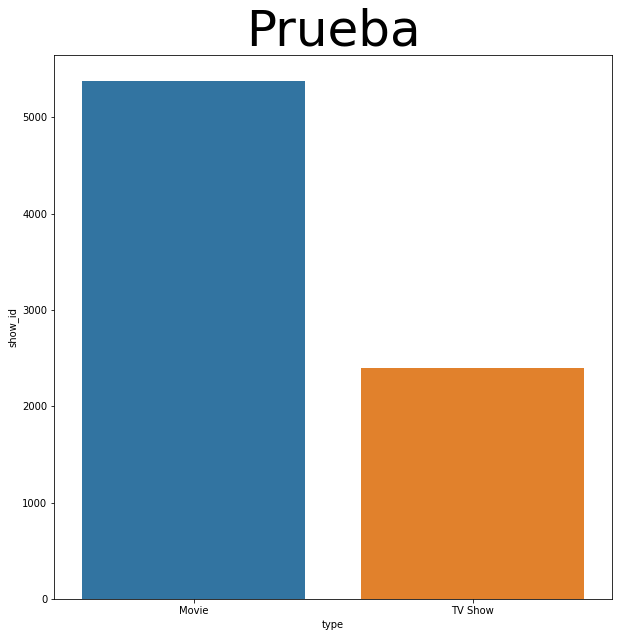

In [21]:
plt.figure(figsize=(10,10))
sns.barplot(data = df.groupby('type').show_id.count().reset_index(),
            x = 'type',
            y = 'show_id');
plt.title('Prueba', size=50);

In [71]:
df[df.type=='Movie'].duration_min.describe().reset_index()

,index,duration_min
0,count,5377.000000
1,mean,99.307978
2,std,28.530881
3,min,3.000000
4,25%,86.000000
5,50%,98.000000
6,75%,114.000000
7,max,312.000000


In [73]:
df[df.type=='TV Show'].duration_seasons.describe().reset_index()

,index,duration_seasons
0,count,792.000000
1,mean,3.305556
2,std,1.954623
3,min,2.000000
4,25%,2.000000
5,50%,3.000000
6,75%,4.000000
7,max,16.000000


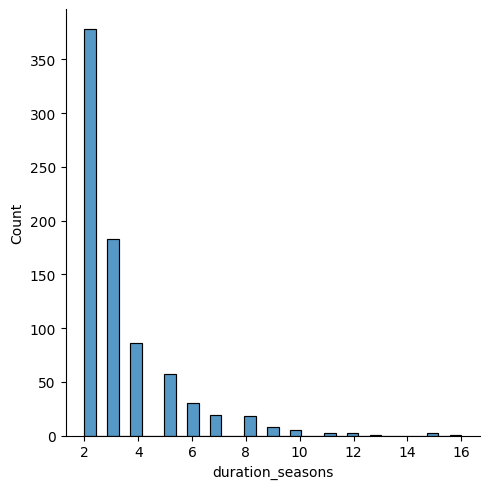

In [74]:
sns.displot(df, x="duration_seasons")

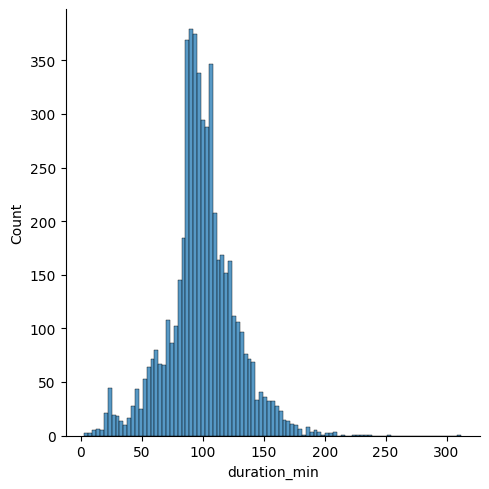

In [75]:
sns.displot(df, x="duration_min")

In [76]:
"""
Reference for matplotlib artists

This example displays several of matplotlib's graphics primitives (artists)
drawn using matplotlib API. A full list of artists and the documentation is
available at http://matplotlib.org/api/artist_api.html.

Copyright (c) 2010, Bartosz Telenczuk
BSD License
"""
import matplotlib.pyplot as plt
plt.rcdefaults()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection


def label(xy, text):
    y = xy[1] - 0.15  # shift y-value for label so that it's below the artist
    plt.text(xy[0], y, text, ha="center", family='sans-serif', size=14)


# fig, ax = plt.subplots()
# create 3x3 grid to plot the artists
# grid = np.mgrid[0.2:0.8:3j, 0.2:0.8:3j].reshape(2, -1).T

# patches = []

# add a fancy box



# colors = np.linspace(0, 1, len(patches))
# collection = PatchCollection(patches, cmap=plt.cm.hsv, alpha=0.3)
# collection.set_array(np.array(colors))
# ax.add_collection(collection)


# # plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
# plt.axis('equal')
# plt.axis('off')



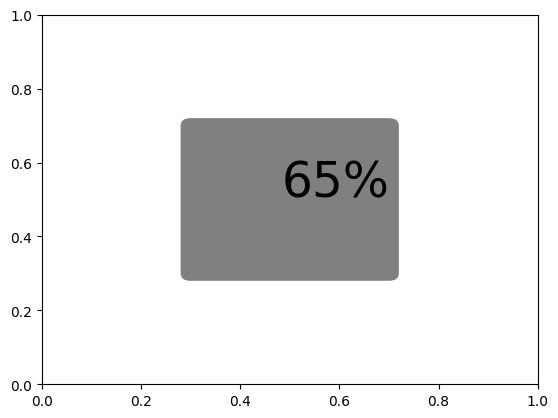

In [79]:
fig, ax = plt.subplots()
fancybox = mpatches.FancyBboxPatch([0.3, 0.3],
                                   0.4, 
                                   0.4, 
                                   boxstyle=mpatches.BoxStyle("Round", pad=0.02),
                                   lw = 0,
                                   color = 'grey')

ax.add_patch(fancybox)
fig.text(x=0.5, y=0.5, s='65%', fontsize=35)
plt.show()